In [1]:
import nltk
import warnings

warnings.filterwarnings('ignore')
nltk.download("all", quiet=True)


True

In [2]:
import random, os
import numpy as np
import torch

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)


In [3]:
import datasets
import pandas as pd
from ast import literal_eval
datasets.set_caching_enabled(False)

data_dir = '/kaggle/input/vispamdataset-v2/preprocessed/'

def load_data(data_dir):
    train_df = pd.read_csv(data_dir + 'train.csv', converters={'categories': literal_eval})
    dev_df = pd.read_csv(data_dir + 'dev.csv', converters={'categories': literal_eval})
    test_df = pd.read_csv(data_dir + 'test.csv', converters={'categories': literal_eval})
    
    train_dataset = datasets.Dataset.from_dict(train_df)
    dev_dataset = datasets.Dataset.from_dict(dev_df)
    test_dataset = datasets.Dataset.from_dict(test_df)
    dataset_dict = datasets.DatasetDict({'train': train_dataset, 'dev': dev_dataset, 'test': test_dataset})
    
    return dataset_dict

vispam_datasets = load_data(data_dir)


In [4]:
import numpy as np
from nltk.tokenize import word_tokenize

def tokenizing(texts):
    max_len = 0
    tokenized_texts = []
    word2idx = {}
    
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    
    idx = 2
    for sent in texts:
        tokenized_sent = word_tokenize(sent)
        tokenized_texts.append(tokenized_sent)
        
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1
                
        max_len = max(max_len, len(tokenized_sent))
        
    return tokenized_texts, word2idx, max_len


def encoding(tokenized_texts, word2idx, max_len=100):
    input_ids = []
    for tokenized_sent in tokenized_texts:
        if len(tokenized_sent) > max_len:
            tokenized_sent = tokenized_sent[:max_len]
            
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))
        
        input_id = [word2idx.get(token, word2idx['<unk>']) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)


train_tokenized, word2idx, max_len = tokenizing(vispam_datasets['train']['clean_tokenized_comment'])
print('Number of words:', len(word2idx))
print('Max length of sentence:', max_len)


Number of words: 17196
Max length of sentence: 217


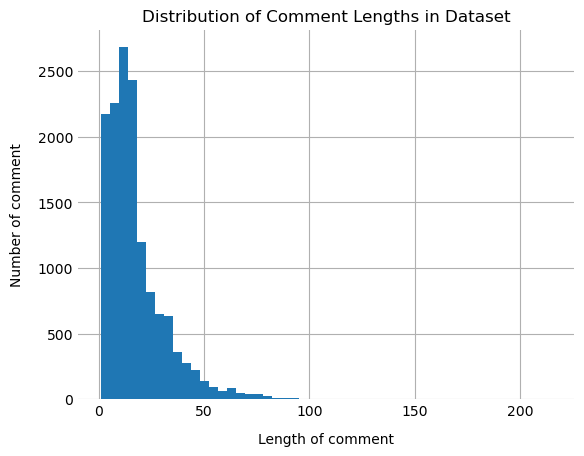

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist([len(s.split()) for s in vispam_datasets['train']['clean_tokenized_comment']], bins=50)
ax.set_title('Distribution of Comment Lengths in Dataset', fontsize=12)
ax.set_xlabel("Length of comment", fontsize=10, labelpad=10)
ax.set_ylabel('Number of comment', fontsize=10, labelpad=10)
for pos in ['right', 'top', 'left', 'bottom']:
    ax.spines[pos].set_visible(False)
ax.tick_params(axis='both', which='both', length=0)
ax.grid()
ax.set_axisbelow(True)
plt.show()


In [6]:
def encode_mapping(examples):
    tokenized_texts = [word_tokenize(sent) for sent in examples['clean_tokenized_comment']]
    input_ids = encoding(tokenized_texts, word2idx, max_len=100)
    
    return {'input_ids': input_ids}


encoded_datasets = vispam_datasets.map(encode_mapping, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-2])
encoded_datasets.set_format("torch")


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [7]:
import torch
import numpy as np
from tqdm import tqdm_notebook

def load_pretrained_vectors(word2idx, file_name):
    fin = open(file_name, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))
    
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)
            
    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")
    
    return embeddings


file_name = "/kaggle/input/fasttext-pretrained-embeddings/cc.vi.300.vec"
embeddings = load_pretrained_vectors(word2idx, file_name)
embeddings = torch.tensor(embeddings)


0it [00:00, ?it/s]

There are 8362 / 17196 pretrained vectors found.


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextCNN(nn.Module):
    def __init__(self, task, kernel_sizes=[2, 3, 5], num_filters=32, drop=0.5, spatial_dropout=False, mode='static'):
        super(TextCNN, self).__init__()
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.vocab_size, self.embedding_dim = embeddings.shape
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.drop = drop
        self.spatial_dropout = spatial_dropout
        self.mode = mode
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=0)
        self.load_embeddings()
        
        if spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(drop)
            
        self.conv = nn.ModuleList([nn.Conv1d(in_channels=self.embedding_dim, out_channels=num_filters, kernel_size=k, stride=1) for k in kernel_sizes])
        self.dropout = nn.Dropout(drop)
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, self.num_classes)

    def forward(self, input_ids):
        batch_size, sequence_length = input_ids.shape
        h_embedding = self.embedding(input_ids).float()
        
        if self.spatial_dropout:
            h_embedding = h_embedding.permute(0, 2, 1)
            h_embedding = self.spatial_dropout1d(h_embedding)
            h_embedding = h_embedding.permute(0, 2, 1)
        
        x = h_embedding.permute(0, 2, 1)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, kernel_size=c.shape[2]).squeeze(dim=2) for c in x]
        x = torch.cat(x, dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

    def load_embeddings(self):
        if 'static' in self.mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in self.mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif self.mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
            

class BiLSTM(nn.Module):
    
    def __init__(self, task, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static'):
        super(BiLSTM, self).__init__()
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.vocab_size, self.embedding_dim = embeddings.shape
        self.hidden_size = hidden_size
        self.drop = drop
        self.spatial_dropout = spatial_dropout
        self.mode = mode
        
        if spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(drop)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=0)
        self.load_embeddings()
        self.lstm = nn.LSTM(self.embedding_dim, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop)
        self.fc = nn.Linear(64, self.num_classes)
        
    def forward(self, input_ids):
        batch_size, sequence_length = input_ids.shape
        h_embedding = self.embedding(input_ids).float()
        
        if self.spatial_dropout:
            h_embedding = h_embedding.permute(0, 2, 1)
            h_embedding = self.spatial_dropout1d(h_embedding)
            h_embedding = h_embedding.permute(0, 2, 1)
        
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.fc(conc)
        
        return out
    
    def load_embeddings(self):
        if 'static' in self.mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in self.mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif self.mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
            

class BiGRU(nn.Module):
    
    def __init__(self, task, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static'):
        super(BiGRU, self).__init__()
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.vocab_size, self.embedding_dim = embeddings.shape
        self.hidden_size = hidden_size
        self.drop = drop
        self.spatial_dropout = spatial_dropout
        self.mode = mode
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=0)
        
        if spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(drop)
        
        self.load_embeddings()
        self.gru = nn.GRU(self.embedding_dim, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size*4, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop)
        self.fc = nn.Linear(64, self.num_classes)
        
    def forward(self, input_ids):
        batch_size, sequence_length = input_ids.shape
        h_embedding = self.embedding(input_ids).float()
        
        if self.spatial_dropout:
            h_embedding = h_embedding.permute(0, 2, 1)
            h_embedding = self.spatial_dropout1d(h_embedding)
            h_embedding = h_embedding.permute(0, 2, 1)
            
        h_gru, _ = self.gru(h_embedding)
        avg_pool = torch.mean(h_gru, 1)
        max_pool, _ = torch.max(h_gru, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.fc(conc)
        
        return out
    
    def load_embeddings(self):
        if 'static' in self.mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in self.mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif self.mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
            

In [9]:
import torch
import numpy as np

class EarlyStopping:
    
    def __init__(self, patience=5, verbose=True, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        
    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model ...')
            
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
        

In [10]:
import os
import gc
import json
import numpy as np
from scipy import interpolate
from pathlib import Path
import torch
from torch import nn
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot, plot

def train_step(model, criterion, optimizer, train_dataloader, task):
    model.train()
    losses = []
    correct = 0
    
    trues = []
    predicts = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in tqdm(train_dataloader):
        input_ids = data['input_ids'].to(device)
        labels = data[label_column].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids)
        
        loss = criterion(outputs, labels)
        pred = torch.max(outputs, dim=1)[1]
        
        correct += torch.sum(pred == labels)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        trues.extend(labels.cpu().detach().numpy())
        predicts.extend(pred.cpu().detach().numpy())
        
    accuracy = correct.double().cpu().data.numpy()/len(train_dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, f1_score(trues, predicts, average='macro'), loss


def validation_step(model, criterion, dataloader, task):
    model.eval()
    losses = []
    correct = 0
    
    trues = []
    predicts = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            labels = data[label_column].to(device)

            outputs = model(input_ids)
            pred = torch.max(outputs, dim=1)[1]
            
            loss = criterion(outputs, labels)
            correct += torch.sum(pred == labels)
            losses.append(loss.item())
            
            trues.extend(labels.cpu().detach().numpy())
            predicts.extend(pred.cpu().detach().numpy())

    accuracy = correct.double().cpu().data.numpy()/len(dataloader.dataset)
    loss = np.mean(losses)

    return accuracy, f1_score(trues, predicts, average='macro'), loss


def train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs, model_name, early_stopping, task):
    torch.cuda.empty_cache()
    gc.collect()
    
    Path(model_name).mkdir(parents=True, exist_ok=True)
    
    if early_stopping:
        path_checkpoint = os.path.join(model_name, f"{model_name}_checkpoint_({task}).pth")
        early_stopping.path = path_checkpoint
    
    best_f1 = 0
    best_model_path = os.path.join(model_name, f"{model_name}_best_model_({task}).pth")
    last_model_path = os.path.join(model_name, f"{model_name}_last_model_({task}).pth")
    history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}

    for epoch in range(epochs):
        print("Epoch {}/{}".format(epoch+1, epochs))
        print("-"*70)
        
        train_accuracy, train_f1, train_loss = train_step(model, criterion, optimizer, train_dataloader, task)
        val_accuracy, val_f1, val_loss = validation_step(model, criterion, val_dataloader, task)
        
        history['train_acc'].append(train_accuracy)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_accuracy)
        history['val_loss'].append(val_loss)
        
        print("Train Accuracy: {:.4f} - Valid F1-score: {:.4f} - Train Loss: {:.4f}".format(train_accuracy, train_f1, train_loss))
        print("Valid Accuracy: {:.4f} - Valid F1-score: {:.4f} - Valid Loss: {:.4f}".format(val_accuracy, val_f1, val_loss))
        
        if val_f1 > best_f1:
            torch.save(model.state_dict(), best_model_path)
            best_f1 = val_f1
        
        if epoch + 1 == epochs:
            torch.save(model.state_dict(), last_model_path)
            break
            
        if early_stopping:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                torch.save(model.state_dict(), last_model_path)
                print("Early stopping.")
                break
    
    history_path = os.path.join(model_name, f"{model_name}_history_({task}).json")
    with open(history_path, 'w') as f:
        json.dump(history, f)
        
    # with open(history_path) as f:
    #     history = json.load(f)
    
    return history
    

def test(model, dataloader, task):
    model.eval()
    
    predicts = []
    predict_probs = []
    true_labels = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in tqdm(dataloader):
        input_ids = data['input_ids'].to(device)
        labels = data[label_column].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids)
         
        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())
        
    return true_labels, predicts


def evaluate(true_labels, predicts):
    test_accuracy = accuracy_score(true_labels, predicts)
    test_precision = precision_score(true_labels, predicts, average='macro')
    test_recall = recall_score(true_labels, predicts, average='macro')
    test_f1 = f1_score(true_labels, predicts, average='macro')
    test_cm = confusion_matrix(true_labels, predicts)

    print("Accuracy: {:.4f}".format(test_accuracy))
    print("Precision: {:.4f}".format(test_precision))
    print("Recall: {:.4f}".format(test_recall))
    print("F1-score: {:.4f}".format(test_f1))
    print("Confusion matrix:\n", test_cm)
    print(classification_report(true_labels, predicts, digits=4))
    
    return test_cm


def save_visualization_history(history, model_name, task):
    colors = plt.get_cmap('tab10').colors
    epochs = np.arange(1, len(history['train_loss']) + 1)
    xnew = np.linspace(epochs[0], epochs[-1], 300)
    
    train_loss_smooth = interpolate.interp1d(epochs, history['train_loss'], kind='linear')(xnew)
    val_loss_smooth = interpolate.interp1d(epochs, history['val_loss'], kind='linear')(xnew)

    fig, ax = plt.subplots()
    ax.plot(xnew, train_loss_smooth, color=colors[0], linewidth=3, label='Training Loss')
    ax.plot(xnew, val_loss_smooth, color=colors[1], linewidth=3, label='Validation Loss')
    ax.set_title('Training and Validation Loss', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Loss', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    for pos in ['right', 'top', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    file_name = os.path.join(model_name, f"{model_name}_loss_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    train_acc_smooth = interpolate.interp1d(epochs, history['train_acc'], kind='linear')(xnew)
    val_acc_smooth = interpolate.interp1d(epochs, history['val_acc'], kind='linear')(xnew)

    fig, ax = plt.subplots()
    ax.plot(xnew, train_acc_smooth, color=colors[2], linewidth=3, label='Training Accuracy')
    ax.plot(xnew, val_acc_smooth, color=colors[4], linewidth=3, label='Validation Accuracy')
    ax.set_title('Training and Validation Accuracy', fontsize=12)
    ax.set_xlabel('Epoch', fontsize=10, labelpad=10)
    ax.set_ylabel('Accuracy', fontsize=10, labelpad=10)
    ax.tick_params(axis='both', which='both', length=0)
    ax.grid(axis='y')
    for pos in ['right', 'top', 'left', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False, prop={'size': 10})
    file_name = os.path.join(model_name, f"{model_name}_accuracy_visualization_({task}).png")
    fig.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.close(fig)


def plotting_history(history):
    assert len(history['train_loss']) == len(history['val_loss'])
    assert len(history['train_acc']) == len(history['val_acc'])
    
    fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Accuracy"), shared_yaxes=False, shared_xaxes=False, vertical_spacing=0.1, horizontal_spacing=0.05)
    
    num_epochs = len(history['train_loss'])
    epoch_labels = list(range(1, num_epochs+1))

    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_loss'], name='train_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_loss'], name='val_loss', legendgroup='1'), row=1, col=1)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['train_acc'], name='train_accuracy', legendgroup='2'), row=1, col=2)
    fig.add_trace(go.Scatter(x=epoch_labels, y=history['val_acc'], name='val_accuracy', legendgroup='2'), row=1, col=2)

    fig.update_layout(legend=dict(orientation="h", xanchor="center", x=0.5), showlegend=True)
    fig.show()
    
    
def plotting_confusion_matrix(confusion_matrix, task):
    if task == 1:
        labels = ['no-spam', 'spam']
        font_size = 30
    else:
        labels = ['no-spam', 'spam-1', 'spam-2', 'spam-3']
        font_size = 22
        
    plt.figure(dpi=100)
    df_cm = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    sns.heatmap(df_cm, annot=True, cmap="Greys", fmt="g", cbar=True, annot_kws={"size": font_size})
    plt.show()
    

In [11]:
import torch
import numpy as np
from sklearn.utils import class_weight

labels = encoded_datasets['train']['label']
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float)

spam_labels = encoded_datasets['train']['spam_label']
spam_class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(spam_labels), y=spam_labels.numpy())
spam_class_weights = torch.tensor(spam_class_weights, dtype=torch.float)

class_weights, spam_class_weights


(tensor([0.6797, 1.8909]), tensor([ 0.3399, 16.9242,  3.2375,  1.4499]))

In [12]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [13]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=256)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=256)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=256)


# TextCNN

## Task 1

In [14]:
import torch
from torch import nn

seed_everything(42)
model = TextCNN(task=1, kernel_sizes=[2, 3, 5], num_filters=32, drop=0.5, spatial_dropout=False, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="TextCNN", early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.7500 - Valid F1-score: 0.6914 - Train Loss: 0.5968
Valid Accuracy: 0.8087 - Valid F1-score: 0.7448 - Valid Loss: 0.5263
Validation loss decreased (inf --> 0.526254). Saving model ...
Epoch 2/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8224 - Valid F1-score: 0.7846 - Train Loss: 0.4483
Valid Accuracy: 0.7961 - Valid F1-score: 0.7547 - Valid Loss: 0.4630
Validation loss decreased (0.526254 --> 0.462979). Saving model ...
Epoch 3/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8573 - Valid F1-score: 0.8288 - Train Loss: 0.3437
Valid Accuracy: 0.8332 - Valid F1-score: 0.7841 - Valid Loss: 0.4557
Validation loss decreased (0.462979 --> 0.455750). Saving model ...
Epoch 4/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8998 - Valid F1-score: 0.8776 - Train Loss: 0.2579
Valid Accuracy: 0.8156 - Valid F1-score: 0.7718 - Valid Loss: 0.4635
EarlyStopping counter: 1 out of 10
Epoch 5/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9278 - Valid F1-score: 0.9105 - Train Loss: 0.1965
Valid Accuracy: 0.8269 - Valid F1-score: 0.7783 - Valid Loss: 0.5153
EarlyStopping counter: 2 out of 10
Epoch 6/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9413 - Valid F1-score: 0.9270 - Train Loss: 0.1556
Valid Accuracy: 0.8206 - Valid F1-score: 0.7671 - Valid Loss: 0.5841
EarlyStopping counter: 3 out of 10
Epoch 7/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9541 - Valid F1-score: 0.9424 - Train Loss: 0.1287
Valid Accuracy: 0.8313 - Valid F1-score: 0.7711 - Valid Loss: 0.6576
EarlyStopping counter: 4 out of 10
Epoch 8/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9609 - Valid F1-score: 0.9508 - Train Loss: 0.1105
Valid Accuracy: 0.8200 - Valid F1-score: 0.7595 - Valid Loss: 0.7133
EarlyStopping counter: 5 out of 10
Epoch 9/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9652 - Valid F1-score: 0.9562 - Train Loss: 0.0952
Valid Accuracy: 0.8169 - Valid F1-score: 0.7579 - Valid Loss: 0.7694
EarlyStopping counter: 6 out of 10
Epoch 10/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9685 - Valid F1-score: 0.9603 - Train Loss: 0.0833
Valid Accuracy: 0.8156 - Valid F1-score: 0.7509 - Valid Loss: 0.8733
EarlyStopping counter: 7 out of 10
Epoch 11/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9711 - Valid F1-score: 0.9635 - Train Loss: 0.0757
Valid Accuracy: 0.8049 - Valid F1-score: 0.7464 - Valid Loss: 0.8731
EarlyStopping counter: 8 out of 10
Epoch 12/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9743 - Valid F1-score: 0.9675 - Train Loss: 0.0699
Valid Accuracy: 0.8150 - Valid F1-score: 0.7528 - Valid Loss: 0.9773
EarlyStopping counter: 9 out of 10
Epoch 13/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9757 - Valid F1-score: 0.9693 - Train Loss: 0.0624
Valid Accuracy: 0.8194 - Valid F1-score: 0.7507 - Valid Loss: 1.1255
EarlyStopping counter: 10 out of 10
Early stopping.


In [15]:
save_visualization_history(history, 'TextCNN', task=1)
plotting_history(history)


In [16]:
import os
import torch

model_name = "TextCNN"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = TextCNN(task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8201
Precision: 0.7714
Recall: 0.7546
F1-score: 0.7621
Confusion matrix:
 [[2603  308]
 [ 405  647]]
              precision    recall  f1-score   support

           0     0.8654    0.8942    0.8795      2911
           1     0.6775    0.6150    0.6447      1052

    accuracy                         0.8201      3963
   macro avg     0.7714    0.7546    0.7621      3963
weighted avg     0.8155    0.8201    0.8172      3963



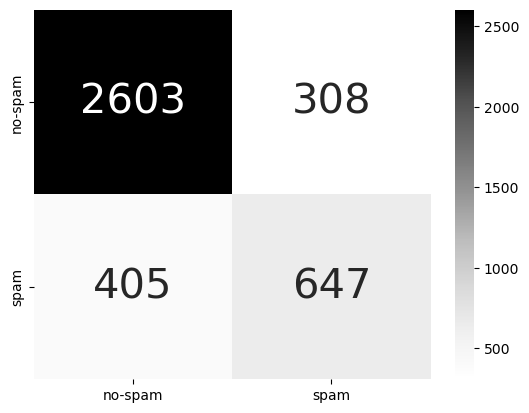

In [17]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [18]:
import torch
from torch import nn

seed_everything(42)
model = TextCNN(task=2, kernel_sizes=[2, 3, 5], num_filters=32, drop=0.5, spatial_dropout=False, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="TextCNN", early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.4971 - Valid F1-score: 0.3435 - Train Loss: 1.1833
Valid Accuracy: 0.5960 - Valid F1-score: 0.3957 - Valid Loss: 1.1506
Validation loss decreased (inf --> 1.150576). Saving model ...
Epoch 2/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.6494 - Valid F1-score: 0.5026 - Train Loss: 0.9254
Valid Accuracy: 0.6866 - Valid F1-score: 0.4914 - Valid Loss: 1.0176
Validation loss decreased (1.150576 --> 1.017614). Saving model ...
Epoch 3/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.7068 - Valid F1-score: 0.5677 - Train Loss: 0.7474
Valid Accuracy: 0.7187 - Valid F1-score: 0.5160 - Valid Loss: 0.9509
Validation loss decreased (1.017614 --> 0.950938). Saving model ...
Epoch 4/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.7384 - Valid F1-score: 0.6100 - Train Loss: 0.6162
Valid Accuracy: 0.7332 - Valid F1-score: 0.5303 - Valid Loss: 0.9277
Validation loss decreased (0.950938 --> 0.927704). Saving model ...
Epoch 5/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.7836 - Valid F1-score: 0.6616 - Train Loss: 0.4870
Valid Accuracy: 0.7281 - Valid F1-score: 0.5265 - Valid Loss: 0.9296
EarlyStopping counter: 1 out of 10
Epoch 6/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8246 - Valid F1-score: 0.7104 - Train Loss: 0.3911
Valid Accuracy: 0.7357 - Valid F1-score: 0.5230 - Valid Loss: 0.9713
EarlyStopping counter: 2 out of 10
Epoch 7/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8508 - Valid F1-score: 0.7382 - Train Loss: 0.3149
Valid Accuracy: 0.7577 - Valid F1-score: 0.5418 - Valid Loss: 1.0588
EarlyStopping counter: 3 out of 10
Epoch 8/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8742 - Valid F1-score: 0.7765 - Train Loss: 0.2531
Valid Accuracy: 0.7778 - Valid F1-score: 0.5501 - Valid Loss: 1.1766
EarlyStopping counter: 4 out of 10
Epoch 9/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8919 - Valid F1-score: 0.7983 - Train Loss: 0.2210
Valid Accuracy: 0.7470 - Valid F1-score: 0.5202 - Valid Loss: 1.1869
EarlyStopping counter: 5 out of 10
Epoch 10/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9049 - Valid F1-score: 0.8183 - Train Loss: 0.1859
Valid Accuracy: 0.7690 - Valid F1-score: 0.5263 - Valid Loss: 1.3363
EarlyStopping counter: 6 out of 10
Epoch 11/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9135 - Valid F1-score: 0.8360 - Train Loss: 0.1680
Valid Accuracy: 0.7785 - Valid F1-score: 0.5338 - Valid Loss: 1.4855
EarlyStopping counter: 7 out of 10
Epoch 12/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9264 - Valid F1-score: 0.8536 - Train Loss: 0.1486
Valid Accuracy: 0.7810 - Valid F1-score: 0.5419 - Valid Loss: 1.5073
EarlyStopping counter: 8 out of 10
Epoch 13/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9294 - Valid F1-score: 0.8581 - Train Loss: 0.1366
Valid Accuracy: 0.7716 - Valid F1-score: 0.5328 - Valid Loss: 1.5981
EarlyStopping counter: 9 out of 10
Epoch 14/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9327 - Valid F1-score: 0.8610 - Train Loss: 0.1307
Valid Accuracy: 0.7841 - Valid F1-score: 0.5355 - Valid Loss: 1.7170
EarlyStopping counter: 10 out of 10
Early stopping.


In [19]:
save_visualization_history(history, 'TextCNN', task=2)
plotting_history(history)


In [20]:
import os
import torch

model_name = "TextCNN"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = TextCNN(task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7865
Precision: 0.5776
Recall: 0.6385
F1-score: 0.5924
Confusion matrix:
 [[2515   38  237  121]
 [  18   29    4    3]
 [ 114    2  180   13]
 [ 228   26   42  393]]
              precision    recall  f1-score   support

           0     0.8748    0.8640    0.8693      2911
           1     0.3053    0.5370    0.3893        54
           2     0.3888    0.5825    0.4663       309
           3     0.7415    0.5704    0.6448       689

    accuracy                         0.7865      3963
   macro avg     0.5776    0.6385    0.5924      3963
weighted avg     0.8060    0.7865    0.7923      3963



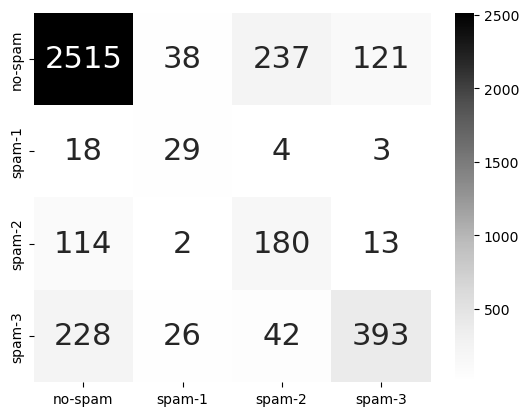

In [21]:
plotting_confusion_matrix(test_cm, task=2)


# BiLSTM

## Task 1

In [22]:
import torch
from torch import nn

seed_everything(42)
model = BiLSTM(task=1, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="BiLSTM", early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.6813 - Valid F1-score: 0.6269 - Train Loss: 0.6344
Valid Accuracy: 0.7948 - Valid F1-score: 0.7405 - Valid Loss: 0.5052
Validation loss decreased (inf --> 0.505200). Saving model ...
Epoch 2/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.7879 - Valid F1-score: 0.7511 - Train Loss: 0.4709
Valid Accuracy: 0.8408 - Valid F1-score: 0.7830 - Valid Loss: 0.4739
Validation loss decreased (0.505200 --> 0.473932). Saving model ...
Epoch 3/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8352 - Valid F1-score: 0.8024 - Train Loss: 0.3982
Valid Accuracy: 0.8414 - Valid F1-score: 0.7899 - Valid Loss: 0.4515
Validation loss decreased (0.473932 --> 0.451532). Saving model ...
Epoch 4/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8650 - Valid F1-score: 0.8365 - Train Loss: 0.3356
Valid Accuracy: 0.8408 - Valid F1-score: 0.7909 - Valid Loss: 0.4614
EarlyStopping counter: 1 out of 10
Epoch 5/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8871 - Valid F1-score: 0.8623 - Train Loss: 0.2834
Valid Accuracy: 0.8502 - Valid F1-score: 0.8009 - Valid Loss: 0.4762
EarlyStopping counter: 2 out of 10
Epoch 6/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9077 - Valid F1-score: 0.8863 - Train Loss: 0.2400
Valid Accuracy: 0.8508 - Valid F1-score: 0.7956 - Valid Loss: 0.5339
EarlyStopping counter: 3 out of 10
Epoch 7/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9209 - Valid F1-score: 0.9020 - Train Loss: 0.2075
Valid Accuracy: 0.8483 - Valid F1-score: 0.7965 - Valid Loss: 0.5385
EarlyStopping counter: 4 out of 10
Epoch 8/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9317 - Valid F1-score: 0.9149 - Train Loss: 0.1753
Valid Accuracy: 0.8320 - Valid F1-score: 0.7841 - Valid Loss: 0.5415
EarlyStopping counter: 5 out of 10
Epoch 9/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9411 - Valid F1-score: 0.9264 - Train Loss: 0.1537
Valid Accuracy: 0.8471 - Valid F1-score: 0.7944 - Valid Loss: 0.6285
EarlyStopping counter: 6 out of 10
Epoch 10/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9481 - Valid F1-score: 0.9350 - Train Loss: 0.1380
Valid Accuracy: 0.8420 - Valid F1-score: 0.7820 - Valid Loss: 0.7235
EarlyStopping counter: 7 out of 10
Epoch 11/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9512 - Valid F1-score: 0.9388 - Train Loss: 0.1295
Valid Accuracy: 0.8383 - Valid F1-score: 0.7844 - Valid Loss: 0.6634
EarlyStopping counter: 8 out of 10
Epoch 12/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9558 - Valid F1-score: 0.9445 - Train Loss: 0.1168
Valid Accuracy: 0.8357 - Valid F1-score: 0.7822 - Valid Loss: 0.7654
EarlyStopping counter: 9 out of 10
Epoch 13/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9607 - Valid F1-score: 0.9505 - Train Loss: 0.1059
Valid Accuracy: 0.8345 - Valid F1-score: 0.7857 - Valid Loss: 0.7334
EarlyStopping counter: 10 out of 10
Early stopping.


In [23]:
save_visualization_history(history, 'BiLSTM', task=1)
plotting_history(history)


In [24]:
import os
import torch

model_name = "BiLSTM"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = BiLSTM(task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8304
Precision: 0.7816
Recall: 0.7950
F1-score: 0.7878
Confusion matrix:
 [[2534  377]
 [ 295  757]]
              precision    recall  f1-score   support

           0     0.8957    0.8705    0.8829      2911
           1     0.6675    0.7196    0.6926      1052

    accuracy                         0.8304      3963
   macro avg     0.7816    0.7950    0.7878      3963
weighted avg     0.8352    0.8304    0.8324      3963



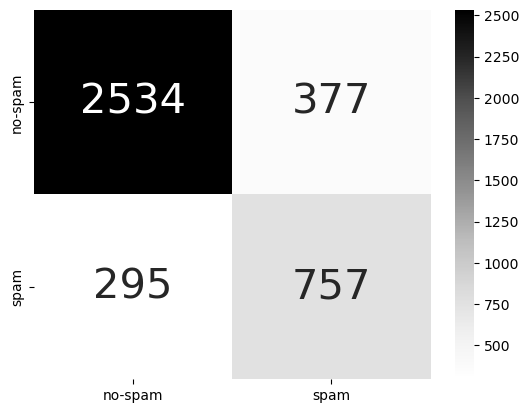

In [25]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [26]:
import torch
from torch import nn

seed_everything(42)
model = BiLSTM(task=2, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="BiLSTM", early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.2995 - Valid F1-score: 0.2285 - Train Loss: 1.3526
Valid Accuracy: 0.5324 - Valid F1-score: 0.4023 - Valid Loss: 1.2862
Validation loss decreased (inf --> 1.286196). Saving model ...
Epoch 2/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.5174 - Valid F1-score: 0.3920 - Train Loss: 1.0454
Valid Accuracy: 0.5123 - Valid F1-score: 0.4247 - Valid Loss: 1.0283
Validation loss decreased (1.286196 --> 1.028296). Saving model ...
Epoch 3/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.6218 - Valid F1-score: 0.4883 - Train Loss: 0.8079
Valid Accuracy: 0.6010 - Valid F1-score: 0.4638 - Valid Loss: 0.8867
Validation loss decreased (1.028296 --> 0.886749). Saving model ...
Epoch 4/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.6995 - Valid F1-score: 0.5684 - Train Loss: 0.6725
Valid Accuracy: 0.7577 - Valid F1-score: 0.5387 - Valid Loss: 0.8455
Validation loss decreased (0.886749 --> 0.845520). Saving model ...
Epoch 5/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.7378 - Valid F1-score: 0.6003 - Train Loss: 0.5581
Valid Accuracy: 0.6847 - Valid F1-score: 0.5105 - Valid Loss: 0.8455
EarlyStopping counter: 1 out of 10
Epoch 6/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.7692 - Valid F1-score: 0.6368 - Train Loss: 0.4873
Valid Accuracy: 0.7476 - Valid F1-score: 0.5557 - Valid Loss: 0.8845
EarlyStopping counter: 2 out of 10
Epoch 7/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8112 - Valid F1-score: 0.6906 - Train Loss: 0.4030
Valid Accuracy: 0.7678 - Valid F1-score: 0.5635 - Valid Loss: 0.9609
EarlyStopping counter: 3 out of 10
Epoch 8/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8296 - Valid F1-score: 0.7155 - Train Loss: 0.3515
Valid Accuracy: 0.7571 - Valid F1-score: 0.5607 - Valid Loss: 1.0378
EarlyStopping counter: 4 out of 10
Epoch 9/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8566 - Valid F1-score: 0.7485 - Train Loss: 0.2970
Valid Accuracy: 0.7873 - Valid F1-score: 0.5723 - Valid Loss: 1.1247
EarlyStopping counter: 5 out of 10
Epoch 10/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8750 - Valid F1-score: 0.7681 - Train Loss: 0.2637
Valid Accuracy: 0.7728 - Valid F1-score: 0.5565 - Valid Loss: 1.1001
EarlyStopping counter: 6 out of 10
Epoch 11/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8793 - Valid F1-score: 0.7846 - Train Loss: 0.2414
Valid Accuracy: 0.7797 - Valid F1-score: 0.5636 - Valid Loss: 1.1083
EarlyStopping counter: 7 out of 10
Epoch 12/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8927 - Valid F1-score: 0.8029 - Train Loss: 0.2263
Valid Accuracy: 0.7992 - Valid F1-score: 0.5835 - Valid Loss: 1.2918
EarlyStopping counter: 8 out of 10
Epoch 13/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8994 - Valid F1-score: 0.8135 - Train Loss: 0.2060
Valid Accuracy: 0.7854 - Valid F1-score: 0.5738 - Valid Loss: 1.3143
EarlyStopping counter: 9 out of 10
Epoch 14/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9101 - Valid F1-score: 0.8263 - Train Loss: 0.1856
Valid Accuracy: 0.7904 - Valid F1-score: 0.5785 - Valid Loss: 1.3934
EarlyStopping counter: 10 out of 10
Early stopping.


In [27]:
save_visualization_history(history, 'BiLSTM', task=2)
plotting_history(history)


In [28]:
import os
import torch

model_name = "BiLSTM"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = BiLSTM(task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7810
Precision: 0.5736
Recall: 0.6808
F1-score: 0.6057
Confusion matrix:
 [[2386   42  327  156]
 [  16   30    6    2]
 [  93    0  203   13]
 [ 145   27   41  476]]
              precision    recall  f1-score   support

           0     0.9038    0.8196    0.8597      2911
           1     0.3030    0.5556    0.3922        54
           2     0.3518    0.6570    0.4582       309
           3     0.7357    0.6909    0.7126       689

    accuracy                         0.7810      3963
   macro avg     0.5736    0.6808    0.6057      3963
weighted avg     0.8233    0.7810    0.7964      3963



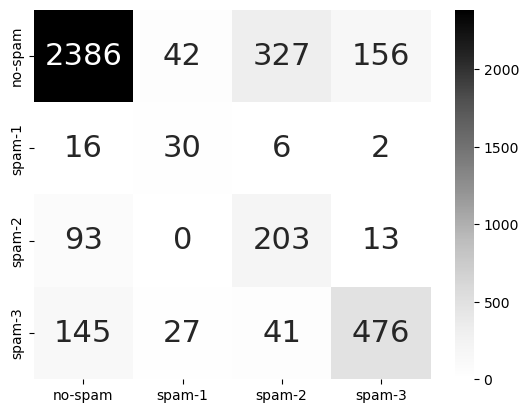

In [29]:
plotting_confusion_matrix(test_cm, task=2)


# BiGRU

## Task 1

In [30]:
import torch
from torch import nn

seed_everything(42)
model = BiGRU(task=1, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="BiGRU", early_stopping=early_stopping, task=1)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.6958 - Valid F1-score: 0.6503 - Train Loss: 0.6039
Valid Accuracy: 0.8112 - Valid F1-score: 0.7542 - Valid Loss: 0.4882
Validation loss decreased (inf --> 0.488238). Saving model ...
Epoch 2/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8080 - Valid F1-score: 0.7696 - Train Loss: 0.4506
Valid Accuracy: 0.8062 - Valid F1-score: 0.7610 - Valid Loss: 0.4386
Validation loss decreased (0.488238 --> 0.438601). Saving model ...
Epoch 3/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8391 - Valid F1-score: 0.8064 - Train Loss: 0.3828
Valid Accuracy: 0.8559 - Valid F1-score: 0.8022 - Valid Loss: 0.4520
EarlyStopping counter: 1 out of 10
Epoch 4/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8726 - Valid F1-score: 0.8442 - Train Loss: 0.3246
Valid Accuracy: 0.8483 - Valid F1-score: 0.7907 - Valid Loss: 0.4663
EarlyStopping counter: 2 out of 10
Epoch 5/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8968 - Valid F1-score: 0.8732 - Train Loss: 0.2683
Valid Accuracy: 0.8452 - Valid F1-score: 0.7985 - Valid Loss: 0.4670
EarlyStopping counter: 3 out of 10
Epoch 6/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9107 - Valid F1-score: 0.8898 - Train Loss: 0.2277
Valid Accuracy: 0.8439 - Valid F1-score: 0.7922 - Valid Loss: 0.5079
EarlyStopping counter: 4 out of 10
Epoch 7/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9224 - Valid F1-score: 0.9039 - Train Loss: 0.1966
Valid Accuracy: 0.8508 - Valid F1-score: 0.7964 - Valid Loss: 0.5426
EarlyStopping counter: 5 out of 10
Epoch 8/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9346 - Valid F1-score: 0.9184 - Train Loss: 0.1688
Valid Accuracy: 0.8433 - Valid F1-score: 0.7890 - Valid Loss: 0.5917
EarlyStopping counter: 6 out of 10
Epoch 9/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9399 - Valid F1-score: 0.9251 - Train Loss: 0.1542
Valid Accuracy: 0.8301 - Valid F1-score: 0.7785 - Valid Loss: 0.5672
EarlyStopping counter: 7 out of 10
Epoch 10/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9483 - Valid F1-score: 0.9351 - Train Loss: 0.1382
Valid Accuracy: 0.8320 - Valid F1-score: 0.7808 - Valid Loss: 0.6450
EarlyStopping counter: 8 out of 10
Epoch 11/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9534 - Valid F1-score: 0.9416 - Train Loss: 0.1205
Valid Accuracy: 0.8357 - Valid F1-score: 0.7792 - Valid Loss: 0.7308
EarlyStopping counter: 9 out of 10
Epoch 12/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9576 - Valid F1-score: 0.9466 - Train Loss: 0.1129
Valid Accuracy: 0.8263 - Valid F1-score: 0.7739 - Valid Loss: 0.7400
EarlyStopping counter: 10 out of 10
Early stopping.


In [31]:
save_visualization_history(history, 'BiGRU', task=1)
plotting_history(history)


In [32]:
import os
import torch

model_name = "BiGRU"
model_path = os.path.join(model_name, f"{model_name}_last_model_(1).pth")
model = BiGRU(task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8259
Precision: 0.7763
Recall: 0.7828
F1-score: 0.7794
Confusion matrix:
 [[2546  365]
 [ 325  727]]
              precision    recall  f1-score   support

           0     0.8868    0.8746    0.8807      2911
           1     0.6658    0.6911    0.6782      1052

    accuracy                         0.8259      3963
   macro avg     0.7763    0.7828    0.7794      3963
weighted avg     0.8281    0.8259    0.8269      3963



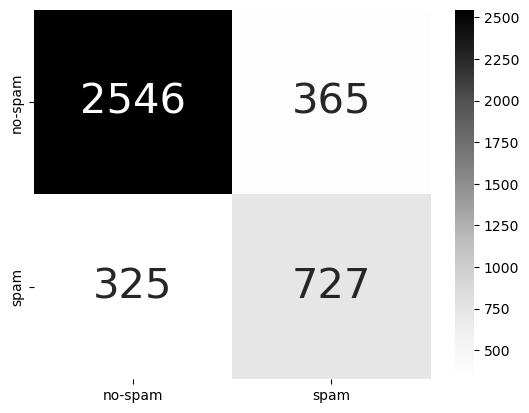

In [33]:
plotting_confusion_matrix(test_cm, task=1)


## Task 2

In [34]:
import torch
from torch import nn

seed_everything(42)
model = BiGRU(task=2, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static').to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=spam_class_weights.to(device), reduction='mean')
early_stopping = EarlyStopping(patience=10, delta=0)
history = train(model, criterion, optimizer, train_dataloader, val_dataloader, epochs=40, model_name="BiGRU", early_stopping=early_stopping, task=2)


Loaded pretrained embeddings, weights are not trainable.
Epoch 1/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.4441 - Valid F1-score: 0.2901 - Train Loss: 1.3246
Valid Accuracy: 0.5035 - Valid F1-score: 0.3740 - Valid Loss: 1.2207
Validation loss decreased (inf --> 1.220698). Saving model ...
Epoch 2/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.5671 - Valid F1-score: 0.4213 - Train Loss: 0.9975
Valid Accuracy: 0.6866 - Valid F1-score: 0.5040 - Valid Loss: 0.9905
Validation loss decreased (1.220698 --> 0.990488). Saving model ...
Epoch 3/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.6673 - Valid F1-score: 0.5321 - Train Loss: 0.7484
Valid Accuracy: 0.6734 - Valid F1-score: 0.5016 - Valid Loss: 0.9006
Validation loss decreased (0.990488 --> 0.900585). Saving model ...
Epoch 4/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.7287 - Valid F1-score: 0.5922 - Train Loss: 0.6130
Valid Accuracy: 0.7313 - Valid F1-score: 0.5341 - Valid Loss: 0.8256
Validation loss decreased (0.900585 --> 0.825607). Saving model ...
Epoch 5/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.7693 - Valid F1-score: 0.6368 - Train Loss: 0.5228
Valid Accuracy: 0.7388 - Valid F1-score: 0.5774 - Valid Loss: 0.8688
EarlyStopping counter: 1 out of 10
Epoch 6/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8005 - Valid F1-score: 0.6683 - Train Loss: 0.4421
Valid Accuracy: 0.7193 - Valid F1-score: 0.5374 - Valid Loss: 0.8971
EarlyStopping counter: 2 out of 10
Epoch 7/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8291 - Valid F1-score: 0.7161 - Train Loss: 0.3812
Valid Accuracy: 0.7753 - Valid F1-score: 0.5796 - Valid Loss: 1.0567
EarlyStopping counter: 3 out of 10
Epoch 8/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8572 - Valid F1-score: 0.7478 - Train Loss: 0.3144
Valid Accuracy: 0.7778 - Valid F1-score: 0.5648 - Valid Loss: 1.1075
EarlyStopping counter: 4 out of 10
Epoch 9/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8740 - Valid F1-score: 0.7778 - Train Loss: 0.2719
Valid Accuracy: 0.7974 - Valid F1-score: 0.5763 - Valid Loss: 1.1619
EarlyStopping counter: 5 out of 10
Epoch 10/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8833 - Valid F1-score: 0.7828 - Train Loss: 0.2479
Valid Accuracy: 0.7841 - Valid F1-score: 0.5597 - Valid Loss: 1.2355
EarlyStopping counter: 6 out of 10
Epoch 11/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.8965 - Valid F1-score: 0.8019 - Train Loss: 0.2231
Valid Accuracy: 0.7627 - Valid F1-score: 0.5497 - Valid Loss: 1.2433
EarlyStopping counter: 7 out of 10
Epoch 12/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9019 - Valid F1-score: 0.8068 - Train Loss: 0.2106
Valid Accuracy: 0.7873 - Valid F1-score: 0.5680 - Valid Loss: 1.2410
EarlyStopping counter: 8 out of 10
Epoch 13/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9078 - Valid F1-score: 0.8223 - Train Loss: 0.1856
Valid Accuracy: 0.7923 - Valid F1-score: 0.5744 - Valid Loss: 1.3423
EarlyStopping counter: 9 out of 10
Epoch 14/40
----------------------------------------------------------------------


  0%|          | 0/56 [00:00<?, ?it/s]

Train Accuracy: 0.9161 - Valid F1-score: 0.8291 - Train Loss: 0.1678
Valid Accuracy: 0.7986 - Valid F1-score: 0.5688 - Valid Loss: 1.5696
EarlyStopping counter: 10 out of 10
Early stopping.


In [35]:
save_visualization_history(history, 'BiGRU', task=2)
plotting_history(history)


In [36]:
import os
import torch

model_name = "BiGRU"
model_path = os.path.join(model_name, f"{model_name}_last_model_(2).pth")
model = BiGRU(task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7845
Precision: 0.5972
Recall: 0.6677
F1-score: 0.6147
Confusion matrix:
 [[2450   31  313  117]
 [  19   30    2    3]
 [ 100    1  202    6]
 [ 190   18   54  427]]
              precision    recall  f1-score   support

           0     0.8880    0.8416    0.8642      2911
           1     0.3750    0.5556    0.4478        54
           2     0.3538    0.6537    0.4591       309
           3     0.7722    0.6197    0.6876       689

    accuracy                         0.7845      3963
   macro avg     0.5972    0.6677    0.6147      3963
weighted avg     0.8192    0.7845    0.7962      3963



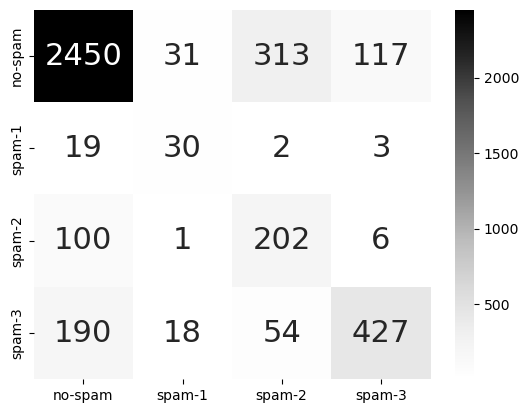

In [37]:
plotting_confusion_matrix(test_cm, task=2)
